In [1]:
# Import libraries
from Bio.PDB import PDBParser # for parsing input structure
from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters,minimize,report_fit # fot fitting helix
import io # for printing output to file
from contextlib import redirect_stdout # for printing output to file
import tempfile
import os

import pyrosetta
#from rosetta import *
pyrosetta.init("-beta_nov16 -mute all")
import pandas as pd
import copy

PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2019.19.post.dev+17.commits.d5a7d8129801bf7eaf383dba4ad48c78085ffd42 2019-05-20T01:48:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [2]:
def find_helix_coords(pose, min_len=3):
    """Given a secondary strucure asignmet, count the number of helices (at least as long as min_len)
    """
    
    if min_len < 1:
        raise ValueError
    
    pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
    
    all_helix_resis=[]
    
    
    for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
        current_helix_resis=[]
        
        for res_num in pyrosetta.rosetta.core.pose.get_resnums_for_chain_id(pose,chain):
            res_ss = pose.secstruct(res_num)
            if res_ss == 'H':
                current_helix_resis.append(res_num)
            else:
                if len(current_helix_resis) >= min_len:
                    all_helix_resis.append(current_helix_resis)
                current_helix_resis = []
        if len(current_helix_resis) >= min_len:
            all_helix_resis.append(current_helix_resis)
    
    #now I need to convert those resis to Calpha coords
    all_helix_coords = []
    for helix in all_helix_resis:
        helix_coords = []
        for res_id in helix:
            
            res = pose.residue(res_id)
            ca = res.atom("CA")
            x,y,z = ca.xyz()
            x = float(x)
            y = float(y)
            z = float(z)
            helix_coords.append([x,y,z])
        arr_helix_coords = np.array(helix_coords)
        all_helix_coords.append(arr_helix_coords)
    return all_helix_coords

In [3]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

# Calculates Rotation Matrix given euler angles and back.
#https://www.learnopencv.com/rotation-matrix-to-euler-angles/
def euler_to_R(phi,theta,psi):
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         np.cos(phi), -np.sin(phi) ],
                    [0,         np.sin(phi), np.cos(phi)  ]
                    ])

    R_y = np.array([[np.cos(theta),    0,      np.sin(theta)  ],
                    [0,                     1,      0                   ],
                    [-np.sin(theta),   0,      np.cos(theta)  ]
                    ])

    R_z = np.array([[np.cos(psi),    -np.sin(psi),    0],
                    [np.sin(psi),    np.cos(psi),     0],
                    [0,                     0,                      1]
                    ])

    R = np.dot(R_z, np.dot( R_y, R_x ))

    return R


def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def R_to_euler(R) :
    assert(isRotationMatrix(R))

    s_y = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])

    singular = s_y < 1e-6

    if  not singular :
        phi = np.arctan2(R[2,1] , R[2,2])
        theta = np.arctan2(-R[2,0], s_y)
        psi = np.arctan2(R[1,0], R[0,0])
    else :
        phi = np.arctan2(-R[1,2], R[1,1])
        theta = np.arctan2(-R[2,0], s_y)
        psi = 0

    return np.array([phi, theta, psi])


def rotation(u,v):
    #a = np.array([0,0,1])
    #b = random_tilt_u(sigma)
    a = normalize(u)
    b = normalize(v)
    
    v = np.cross(a,b)
    s = np.linalg.norm(v) #?
    c = a.dot(b)
    I = np.identity(3)
    
    #vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0, -v[2], v[1], v[2], 0, -v[0], -v[1], v[0], 0)
    #k = np.matrix(vXStr)
    
    k = np.array([[0 , -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    
    R = I + k + np.matmul(k,k) * ((1 -c)/(s**2))
    assert(isRotationMatrix(R))
    return R


u = [0,0,1]
v = normalize([1,1,1])
R1 = rotation(u,v)
print(R1)
print(R1.dot(u),v)




class HelixParameters():
    def __init__(self,r0=None,omega0=None,omega1=None,phi0=None,phi1=None,delta_z=None,invert=None,helix_length=None,z_aligned=False,translate_x=None,translate_y=None,translate_z=None,rotate_phi=None,rotate_theta=None,rotate_psi=None):
        self._r0,self._omega0,self._omega1,self._phi0,self._phi1,self._delta_z,self._invert,self._length,self._d,self._r1 = (None,)*10
        
        self._translate_x, self._translate_y, self._translate_z, self._rotate_phi, self._rotate_theta,self._rotate_psi = (None,)*6
        
        self.r0(r0)
        self.omega0(omega0)
        self.omega1(omega1)
        self.phi0(phi0)
        self.phi1(phi1)
        self.delta_z(delta_z)
        self.invert(invert)
        self.length(helix_length)
        self._d = 1.51 # FIXED, distance between successive residues along the helical axis, [angstrom] -- BundleGridSampler=z1
        self._r1 = 2.26 # FIXED, helical radius, [angstrom] -- BundleGridSampler=r1_peratom        
        
        self.z_aligned = z_aligned
        
        if self.z_aligned and any([translate_x,translate_y,translate_z,rotate_phi,rotate_theta,rotate_psi]):
            raise ValueError("no transformation parameters are allowed in z_aligned mode")
        
        if not self.z_aligned:
            self.translate_x(translate_x)
            self.translate_y(translate_y)
            self.translate_z(translate_z)
            self.rotate_phi(rotate_phi)
            self.rotate_theta(rotate_theta)
            self.rotate_psi(rotate_psi)
    
    def __repr__(self):
        return f'Helical Parameters: r0={self.r0()},omega0={self.omega0()},omega1={self.omega1()},phi0={self.phi0()},' \
               f'phi1={self.phi1()},delta_z={self.delta_z()},d={self.d()},r1={self.r1()},' \
               f'translate_x={self.translate_x()},translate_y={self.translate_y()},translate_z={self.translate_z()},' \
               f'rotate_phi={self.rotate_phi()},rotate_theta={self.rotate_theta()},rotate_psi={self.rotate_psi()},' \
               f'invert={self.invert()},length={self.length()}'
    
    #hybrid setters/getters. They will always return the value you ask for, but if you pass 
    #something to the function, it'll update the stored value and then return the (updated) value
    def r0(self,r0:float=None):
        if r0 is not None:
            assert(r0 >0)
            #assert(r0 <= 20)
            self._r0 = r0
        return self._r0
        
    def omega0(self,omega0:float=None):
        if omega0 is not None:
            self._omega0 = omega0
        return self._omega0
            
    def omega1(self,omega1:float=None):    
        if omega1 is not None:
            self._omega1 = omega1
        return self._omega1
    
    def phi0(self,phi0:float=None):
        if phi0 is not None:
            assert(phi0 >= 0) #enforece pos only
            self._phi0 = phi0
        return self._phi0
    
    def phi1(self,phi1:float=None):
        if phi1 is not None:
            self._phi1 = phi1
        return self._phi1
    
    def delta_z(self,delta_z:float=None):
        if delta_z is not None:
            self._delta_z = delta_z
        return self._delta_z
    
    def invert(self,invert:bool=None):
        if invert is not None:
            self._invert = invert
        return self._invert
    
    def length(self,length:int=None):
        if length is not None:
            self._length = length
        return self._length
    
    def d(self,d:float=None):
        if d is not None:
            warnings.warn("HelixParamaters variable d is a physical constraint should not be touched")
            self._d = d
        return self._d
    
    def r1(self,r1:float=None):
        if r1 is not None:
            warnings.warn("HelixParamaters variable r1 is a physical constraint should not be touched")
            self._r1 = r1
        return self._r1
    
    
    #new axis independent code
    def translate_x(self,x:float=None):
        if x is not None:
            self._translate_x = x
        #print(f"self._translate_x: {self._translate_x}")
        return self._translate_x
    
    def translate_y(self,y:float=None):
        if y is not None:
            self._translate_y = y
        #print(f"self._translate_y: {self._translate_y}")
        return self._translate_y
    
    def translate_z(self,z:float=None):
        if z is not None:
            self._translate_z = z
        #print(f"self._translate_z: {self._translate_z}")
        return self._translate_z
    
    def rotate_phi(self,phi:float=None):
        if phi is not None:
            self._rotate_phi = phi
        #print(f"self._rotate_phi: {self._rotate_phi}")
        return self._rotate_phi
    
    def rotate_theta(self,theta:float=None):
        if theta is not None:
            self._rotate_theta = theta
        #print(f"self._rotate_theta: {self._rotate_theta}")
        return self._rotate_theta
    
    def rotate_psi(self,psi:float=None):
        if psi is not None:
            self._rotate_psi = psi
        #print(f"self._rotate_psi: {self._rotate_psi}")
        return self._rotate_psi
    
    def transformation_matrix(self):
        if self.z_aligned:
            return np.identity(4)
            
            
        R = euler_to_R(self.rotate_phi(),self.rotate_theta(),self.rotate_psi())
        #print(R)
        #R.resize(4,4)
        M = np.append(np.append(R,[[0]*3],axis=0),[[0]]*4,axis=1)
        #print(M)
        M[3][3] = 1
        M[0][3] = self.translate_x()
        M[1][3] = self.translate_y()
        M[2][3] = self.translate_z()
        #print(M)
        return M
    
    def to_lmfit_parameters(self, round_num=None):
        if self.z_aligned and round_num is not None:
            raise ValueError("z aligned mode only has one round. Just don't set round_num")
        
        if self.z_aligned:
            params = Parameters()
            params.add('r0', value=self.r0(), min=0.000001, max=40, vary=True) # avoid negative radii
            params.add('omega0', value=self.omega0(), vary=True)
            params.add('omega1', value=self.omega1(),  vary=True)
            params.add('phi0', value=self.phi0(), min=0,vary=True) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=True)
            params.add('invert', value=self.invert(), vary=False)
            
            return params
        
        if round_num is None:
            params = Parameters()
            params.add('r0', value=self.r0(), min=0.0000000001, max=20, vary=True) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=True)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=True) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)")
            params.add('phi0', value=self.phi0(), min=0,vary=False) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #r0*omega0 = d * sin(alpha)





        
            return params
        
        elif round_num == 1:
            params = Parameters()
            params.add('r0', value=self.r0(), min=5, max=20, vary=False) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=False)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=False) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)",vary=False)
            params.add('phi0', value=self.phi0(), min=0,vary=False) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #axis independent code:
            params.add('translate_x', value=self.translate_x(),vary=True)
            params.add('translate_y', value=self.translate_y(),vary=True)
            params.add('translate_z', value=self.translate_z(),vary=True)
            params.add('rotate_phi', value=self.rotate_phi(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_theta', value=self.rotate_theta(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_psi',value=self.rotate_psi(),min=-np.pi,max=np.pi,vary=True)
        
            return params
        
        elif round_num == 2:
            params = Parameters()
            params.add('r0', value=self.r0(), min=5, max=20, vary=True) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=True)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=True) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)",vary=True)
            params.add('phi0', value=self.phi0(), min=0,vary=True) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #axis independent code:
            params.add('translate_x', value=self.translate_x(),vary=False)
            params.add('translate_y', value=self.translate_y(),vary=False)
            params.add('translate_z', value=self.translate_z(),vary=False)
            params.add('rotate_phi', value=self.rotate_phi(),min=-np.pi,max=np.pi,vary=False)
            params.add('rotate_theta', value=self.rotate_theta(),min=-np.pi,max=np.pi,vary=False)
            params.add('rotate_psi',value=self.rotate_psi(),min=-np.pi,max=np.pi,vary=False)
        
            return params
        
        elif round_num == 3:
            params = Parameters()
            params.add('r0', value=self.r0(), min=5, max=20, vary=True) # avoid zero

            params.add('omega0', value=self.omega0(),min=radians(-10),max=radians(10), vary=True)
            #params.add('d', value=self.d(),vary=False)
            #params.add('omega0', value=self.omega0(), expr='r0/d')
            #print("I attempted to tie these values together but I'm not sure it worked")

            params.add('omega1', value=self.omega1(),min=radians(80),max=radians(120), vary=True) #TODO:use a function constraint to tie omega0 and omega1 together
            params.add('omega1_omega0_coupling', value=0,min=radians(-10),max=radians(10),expr="abs(omega0+omega1)-radians(100)")
            params.add('phi0', value=self.phi0(), min=0,vary=False) # enforce positive values only
            params.add('phi1', value=self.phi1(),vary=True)
            params.add('delta_z', value=self.delta_z(), vary=False) #taken care of by axis_independent code?
            params.add('invert', value=self.invert(), vary=False)

            #r0*omega0 = d * sin(alpha)




            #axis independent code:
            params.add('translate_x', value=self.translate_x(),vary=True)
            params.add('translate_y', value=self.translate_y(),vary=True)
            params.add('translate_z', value=self.translate_z(),vary=True)
            params.add('rotate_phi', value=self.rotate_phi(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_theta', value=self.rotate_theta(),min=-np.pi,max=np.pi,vary=True)
            params.add('rotate_psi',value=self.rotate_psi(),min=-np.pi,max=np.pi,vary=True)
        
            return params
        else:
            print(f"round_num {round_num} not recognized")
            return None
    
    
    def from_lmfit(self, fit):
        self.r0(fit.valuesdict()['r0'])
        self.omega0(fit.valuesdict()['omega0'])
        self.omega1(fit.valuesdict()['omega1'])
        self.phi0(fit.valuesdict()['phi0'])
        self.phi1(fit.valuesdict()['phi1'])
        self.delta_z(fit.valuesdict()['delta_z'])
        self.invert(fit.valuesdict()['invert'])
        
        if not self.z_aligned:

            self.translate_x(fit.valuesdict()['translate_x'])
            self.translate_y(fit.valuesdict()['translate_y'])
            self.translate_z(fit.valuesdict()['translate_z'])
            self.rotate_phi(fit.valuesdict()['rotate_phi'])
            self.rotate_theta(fit.valuesdict()['rotate_theta'])
            self.rotate_psi(fit.valuesdict()['rotate_psi'])
        
       
    def get_dict(self):
        d = {
            'r0':self.r0(),
            'omega0':self.omega0(),
            'omega1':self.omega1(),
            'phi0':self.phi0(),
            'phi1':self.phi1(),
            'delta_z':self.delta_z(),
            'd':self.d(),
            'r1':self.r1(),
            'translate_x':self.translate_x(),
            'translate_y':self.translate_y(),
            'translate_z':self.translate_z(),
            'rotate_phi':self.rotate_phi(),
            'rotate_theta':self.rotate_theta(),
            'rotate_psi':self.rotate_psi(),
            'invert':self.invert(),
            'length':self.length()
        }
        
        return d

import warnings 

class ParametricFit():
    def __init__(self, name, fit=None, write_axis=False):
        self._name = None
        self.write_axis = write_axis
        if self.write_axis:
            self.axis_movie = []
        self.fit = pd.DataFrame()
        self.coordinate_movie = []
        self.rmsd = []
        self.parameter_history=[]
        if name is None:
            name = "parametric_fit"
        self.name(name)

        if fit is not None:
            self.parse_fit(fit)
            
    #this really should only be accessed by the ParametricHelix class
    #take a fit and 
    def parse_fit(self, fit):
        self.fit = fit
        warnings.warn("PARSE_FIT NOT IMPLEMENTED")
    
    def name(self,name:str=None):
        if name is not None:
            self._name = name
        return self._name
    
    def append_trajectory_rmsd(self,rmsd):
        self.rmsd.append(rmsd)

    def append_trajectory_coords(self,coords, axis=None):
        self.coordinate_movie.append(coords)
        if self.write_axis:
            self.axis_movie.append(axis)

    def write_trajectory_movie(self, filename):
        # Generate movie PDB of fitting trajectories
        f=open(filename,'w')
        model=1
        for coord_frame,ax_frame in zip(self.coordinate_movie,self.axis_movie):
            resid=1
            atomnumb=2
            f.write('MODEL{:>8s}\n'.format(str(model)))  
            for i in coord_frame:
                f.write('ATOM{:>7s}  CA  ALA A{:>4s}     {:>7.3f} {:>7.3f} {:>7.3f}  1.00  0.00           C\n'.format(str(atomnumb),str(resid),float(i[0]),float(i[1]),float(i[2])))
                resid=resid+1
                atomnumb=atomnumb+10
            if self.write_axis:
                for i in ax_frame:
                    f.write('ATOM{:>7s}  CA  ALA B{:>4s}     {:>7.3f} {:>7.3f} {:>7.3f}  1.00  0.00           C\n'.format(str(atomnumb),str(resid),float(i[0]),float(i[1]),float(i[2])))
                    resid=resid+1
                    atomnumb=atomnumb+10
            f.write('TER\n')
            f.write('ENDMDL\n')
            model=model+1
        f.write('END')
        f.close()

    def plot_trajectory_rmsd(self, ax=None):
        # Plot minimization trajectories
        
        if ax is None:
            fig, ax = plt.subplots()
        #warning, don't know how to get fig if ax is passed to us. Do I need fig? probably not
        plt.plot(self.rmsd, axes=ax, label=self.name())
        ax.set_title('Minimization trajectory')
        ax.set_xlabel('Minimization steps')
        ax.set_ylabel('RMSD ($\AA$)')
        plt.legend(loc='best')
        print("final rmsd: " + str(self.rmsd[-1]))
        return ax
    
    def plot_trajectory_parameter(self, parameter:str=None, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        #warning, don't know how to get fig if ax is passed to us. Do I need fig? probably not

        data = [timepoint[parameter] for timepoint in self.parameter_history]
        plt.plot(data, axes=ax, label=self.name())
        ax.set_title('Minimization trajectory for ' + parameter)
        ax.set_xlabel('Minimization steps')
        ax.set_ylabel('parameter value')
        plt.legend(loc='best')
        return ax
    
    def append_trajectory_parameters(self,hp:HelixParameters=None):
        self.parameter_history.append(hp.get_dict())
    




class ParametricHelix():
    def __init__(self,name:str=None,z_aligned:bool=False):
        self.helix_parameters = HelixParameters()
        self._name = None
        self.name(name)
        self.z_aligned = z_aligned
    
    def name(self,name:str=None):
        if name is not None:
            self._name = name
        return self._name
    
    def is_named(self):
        return self._name is not None
    
    def get_helix_parameters(self):
        #may want to make this a deep copy? 
        return self.helix_parameters

    #### FUNCTIONS ####

    # Parametric helix equation based on Huang et al. equations as described in SI 
    # Contains small patch to make it compatible with BundleGridSampler mover (due to differences in origin definition)

    #----------MAKE CARTESIAN COORDINATES FOR CA OF RESIDUE t---------------
    def cartesian(self,t):
    #def cartesian(r0, omega0, omega1, phi0, phi1, delta_z):
        
        # d AND r1 SHOULD NOT BE VARIED IF WANT TO RETAIN IDEAL ALPHA-HELIX
        d = self.helix_parameters.d()
        r1 = self.helix_parameters.r1()
        r0 = self.helix_parameters.r0()
        omega0 = self.helix_parameters.omega0()
        omega1 = self.helix_parameters.omega1()
        phi0 = self.helix_parameters.phi0()
        phi1 = self.helix_parameters.phi1()
        delta_z = self.helix_parameters.delta_z()

        # ONLY FUNCTIONS OF OTHER PARAMETERS
        pre_asin = np.clip((r0*omega0)/d,-1,1) #ryan added this hack
        alpha=asin(pre_asin) # CONSTRAINED (function of other variables), pitch angle, [radians] -- BundleGridSampler=delta_omega1_peratom?
        phi_prime0=phi0+delta_z*tan(alpha)/r0 # CONSTRAINED (function of other variables), superhelical phase decoupled from delta_z, [radians] 

        x=r0*cos(omega0*t+phi_prime0)+r1*cos(omega0*t+phi_prime0)*cos(omega1*t+phi1)-r1*cos(alpha)*sin(omega0*t+phi_prime0)*sin(omega1*t+phi1)
        y=r0*sin(omega0*t+phi_prime0)+r1*sin(omega0*t+phi_prime0)*cos(omega1*t+phi1)+r1*cos(alpha)*cos(omega0*t+phi_prime0)*sin(omega1*t+phi1)
        z=((omega0*r0)/(tan(alpha)))*t-r1*sin(alpha)*sin(omega1*t+phi1)+delta_z

        return [x,y,z]


    #---------MAKE ARRAY OF XYZ COORDINATES FOR ALL CA-----------------------
    #residue_indices would be given like Huang's convention but 0 indexed (0 = first res). Going under the first res means negative numbers
    def moving(self,residue_indices=None):
        
        if residue_indices is None:
            # PATCH TO BRIDGE DIFFERENCES IN HOW THE 'ORIGIN' IS DEFINED
            delta_t=int(self.helix_parameters.length()/2)# define an offset of half-helix length (in number of residues) -- BundleGridSampler=delta_t
            # 're-number' indices +/- around middle of helix
            # to patch Vikram's convention (start from middle of helix) and Huang's convention (start at resid 1) 

            
            
            # Correct for helices that have odd numbers of residues (otherwise fitting helix will be one residue short)
            if (self.helix_parameters.length() % 2) == 0:
                residue_renumber_indices=np.arange(-delta_t,+delta_t,1)
            if (self.helix_parameters.length() % 2) != 0:
                residue_renumber_indices=np.arange(-delta_t,+delta_t+1,1)


            if self.helix_parameters.invert(): # change direction of helix
                residue_renumber_indices=-1*residue_renumber_indices
        
        else:
            
            residue_renumber_indices = residue_indices
            print('this is almost certainly not what I wnat to do')
        
        moving_coordinates = np.array([self.cartesian(t) for t in residue_renumber_indices])

        return moving_coordinates



    
    def Ca_coords_from_stored_params(self,axis=False,residue_indices=None):
        #print("Ca_coords_from_stored_params")
        #print("residue_indices")
        #print(residue_indices)
        move = self.moving(residue_indices)
        #print("move")
        #print(move)
        padded_move = np.append(move,[[1]]*move.shape[0], axis = 1)
        transformed = self.helix_parameters.transformation_matrix().dot(padded_move.T).T
        striped_transformed = np.delete(transformed,3,axis=1)
        
        
        if axis:
            axis = np.array([[0,0,-10],[0,0,10]])
            padded_axis = np.append(axis,[[1]]*axis.shape[0], axis = 1)
            transformed_axis = self.helix_parameters.transformation_matrix().dot(padded_axis.T).T
            striped_axis = np.delete(transformed_axis,3,axis=1)
            
            return striped_transformed, striped_axis
        else:
            return striped_transformed
    
#-----------Objective RMSD function used during minimization---------------    
    def rmsd_array(self,params, target, dummy):
#         r0=params['r0']
#         omega0=params['omega0'] 
#         omega1=params['omega1'] 
#         phi0=params['phi0']
#         phi1=params['phi1'] 
#         delta_z=params['delta_z']
#         invert=params['invert']
        self.helix_parameters.from_lmfit(params)
        
#         move = self.moving()
        
#         axis = np.array([[0,0,-10],[0,0,10]])
        
#         #print(move)
#         #print(move.shape)
#         padded_move = np.append(move,[[1]]*move.shape[0], axis = 1)
#         padded_axis = np.append(axis,[[1]]*axis.shape[0], axis = 1)
#         #print(padded_move)
#         #print(self.helix_parameters.transformation_matrix())
#         transformed = self.helix_parameters.transformation_matrix().dot(padded_move.T).T
#         transformed_axis = self.helix_parameters.transformation_matrix().dot(padded_axis.T).T
#         #print(transformed)
        
#         striped_transformed = np.delete(transformed,3,axis=1)
#         striped_axis = np.delete(transformed_axis,3,axis=1)
#         #print(striped_transformed)
        striped_transformed,striped_axis = self.Ca_coords_from_stored_params(axis=True)
        
        subtract_coord=striped_transformed-target

        rmsd_array=np.sqrt(np.sum(np.power(subtract_coord,2),axis=1))
        rmsd=np.sqrt((1/self.helix_parameters.length())*np.sum(np.sum(np.power(subtract_coord,2),axis=1)))
        
        self.fit.append_trajectory_rmsd(rmsd)
        self.fit.append_trajectory_coords(striped_transformed,striped_axis)
        self.fit.append_trajectory_parameters(self.helix_parameters)

        print(f'rmsd={rmsd}')
        
        return rmsd_array
    
    
    #meant for users to use
    #pose is assumed to be a single helix that I want to know about
    def fit_target_helix(self,pose, write_axis=False):
        if(not self.z_aligned):
    #         self.fit = ParametricFit(self.name(),write_axis=write_axis)

    #         #this gets all the coordinates. I only need Calphas
    #         #target_coords = [ [ pose.residue( r.xyz(a)) for a in range(1, pose.residue(r).natoms() + 1)] for r in range(1, pose.total_residue() + 1)]

    #         target_helix = np.array([np.array(pose.residue(r).atom("CA").xyz()) for r in range(1, pose.total_residue() + 1)])

    #         helix_length=len(target_helix) # number of residues in the helix, [aa]

    #         # not 100% sure this code will be necessary after the coordinate independence upgrade
    #         if (target_helix[-1]-target_helix[0])[2]<0: # check helix orientation
    #             invert=True
    #         else:
    #             invert=False

    #         #some guesses
    #         r0_guess=0.00001 # VARY, superhelical radius, [angstrom] -- BundleGridSampler=r0
    #         delta_z_guess=0 # VARY, offest along the z axis, [angstrom] -- BundleGridSampler=z0_offset
    #         phi1_guess=radians(0) # VARY, helical phase (around the internal axis of that helix), [degrees] -- BundleGridSampler=delta_omega1
    #         #phi0_guess=radians(180) # FIXED? superhelical phase, i.e. 0, 90, 180, 270 for 4 evenly spaced helices, [degrees] -- BundleGridSampler=delta_omega0
    #         omega0_guess=radians(-2.85) # FIXED? superhelical twist (-2.85 degrees for two layers), relates to omega1, [degrees] -- BundleGridSampler=omega0
    #         omega1_guess=radians(+102.85) # FIXED? helical twist (+102.85 degrees for two layers), relates to omega0, [degrees] -- BundleGridSampler=omega1

    #         # Generate quick estimates of phi0 to pass as better guess to avoid convergence problems and math domain errors
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant I
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant II
    #             phi0_guess=radians(180-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant III
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0])))+180)
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant IV
    #             phi0_guess=radians(360-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))

    #         phi0_guess=0

    # #         #guess about transform        
    # #         translate_x_guess = 0
    # #         translate_y_guess = 0
    # #         translate_z_guess = 0
    # #         rotate_phi_guess = 0
    # #         rotate_theta_guess = 0
    # #         rotate_psi_guess = 0

    #         #I can do better than that
    #         helical_pseudo_axis = normalize(target_helix[-1] - target_helix[0])
    #         helical_pseudo_origin = (target_helix[0] + target_helix[-1])/2
    #         #print(target_helix[0],target_helix[-1],helical_pseudo_axis,helical_pseudo_origin)
    #         exit("something about the pseduo_axis is bad")
    #         rotate_phi_guess,rotate_theta_guess,rotate_psi_guess = R_to_euler(rotation(helical_pseudo_axis,[0,0,-1]))
    #         translate_x_guess,translate_y_guess,translate_z_guess = helical_pseudo_origin



    #         #input guesses
    #         self.helix_parameters=HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert,helix_length,translate_x_guess,translate_y_guess,translate_z_guess,rotate_phi_guess,rotate_theta_guess,rotate_psi_guess)

    #         #-----GENERATE PARAMETER DICTIONARY-----------



    #         params = self.helix_parameters.to_lmfit_parameters()

    #         # FIT
    #         fit=minimize(self.rmsd_array,params,method='bfgs',args=(target_helix,True),**{"options":{"maxiter":1000}}) #,**{"ftol":1.e-3}


    #         #self.helix_parameters.from_lmfit(fit)

    #         self.fit.parse_fit(fit)



            #3 step fitting
            #1) using a slightly supercoiled helix, fit the transform, everything else fixed
            #2) using the fitted transform as fixed variables, fit the helical parameters
            #3) fit everything,initialized with previous fits, to work out kinks


            self.fit = ParametricFit(self.name(),write_axis=write_axis)

            #this gets all the coordinates. I only need Calphas
            #target_coords = [ [ pose.residue( r.xyz(a)) for a in range(1, pose.residue(r).natoms() + 1)] for r in range(1, pose.total_residue() + 1)]

            target_helix = np.array([np.array(pose.residue(r).atom("CA").xyz()) for r in range(1, pose.total_residue() + 1)])

            helix_length=len(target_helix) # number of residues in the helix, [aa]

    #         # not 100% sure this code will be necessary after the coordinate independence upgrade
    #         if (target_helix[-1]-target_helix[0])[2]<0: # check helix orientation
    #             invert=True
    #         else:
    #             invert=False
            invert_guess=True

            #some guesses
            r0_guess=5 # VARY, superhelical radius, [angstrom] -- BundleGridSampler=r0
            delta_z_guess=0 # VARY, offest along the z axis, [angstrom] -- BundleGridSampler=z0_offset
            phi1_guess=radians(0) # VARY, helical phase (around the internal axis of that helix), [degrees] -- BundleGridSampler=delta_omega1
            #phi0_guess=radians(180) # FIXED? superhelical phase, i.e. 0, 90, 180, 270 for 4 evenly spaced helices, [degrees] -- BundleGridSampler=delta_omega0
            omega0_guess=radians(-2.85) # FIXED? superhelical twist (-2.85 degrees for two layers), relates to omega1, [degrees] -- BundleGridSampler=omega0
            omega1_guess=radians(+102.85) # FIXED? helical twist (+102.85 degrees for two layers), relates to omega0, [degrees] -- BundleGridSampler=omega1


            #make estimates of phi0 using a target helix aligned to z

    #         # Generate quick estimates of phi0 to pass as better guess to avoid convergence problems and math domain errors
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant I
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant II
    #             phi0_guess=radians(180-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
    #         if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant III
    #             phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0])))+180)
    #         if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant IV
    #             phi0_guess=radians(360-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))

            phi0_guess=0#radians(90)

            #guess about transform        
    #         translate_x_guess = 0
    #         translate_y_guess = 0
    #         translate_z_guess = 0
    #         rotate_phi_guess = 0
    #         rotate_theta_guess = 0
    #         rotate_psi_guess = 0

    #         #I can do better than that
            helical_pseudo_axis = normalize(target_helix[-1] - target_helix[0])
            helical_pseudo_origin = (target_helix[0] + target_helix[-1])/2
            #print(target_helix[0],target_helix[-1],helical_pseudo_axis,helical_pseudo_origin)




            rotate_phi_guess,rotate_theta_guess,rotate_psi_guess = R_to_euler(rotation([0,0,-1],helical_pseudo_axis))
            translate_x_guess,translate_y_guess,translate_z_guess = helical_pseudo_origin


            #According to Basile and Nick, the transformation I use is actually degenerate over 180deg so it won't correclty account for fully inverted helices
            #to fix this, I present the following hack
            orig_hp = HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert_guess,helix_length,False,translate_x_guess,translate_y_guess,translate_z_guess,rotate_phi_guess,rotate_theta_guess,rotate_psi_guess)
            self.helix_parameters=orig_hp
    #         orig_init_helix = Ca_coords_from_stored_params()
    #         orig_subtract_coord=orig_init_helix-target
    #         original_rmsd=np.sqrt((1/self.helix_parameters.length())*np.sum(np.sum(np.power(orig_subtract_coord,2),axis=1)))

    #         invert_hp = orig_hp = HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert_guess,helix_length,translate_x_guess,translate_y_guess,translate_z_guess,rotate_phi_guess,rotate_theta_guess,rotate_psi_guess)
    #         #wait, let's just try this

            #input guesses


            # FIT
            print("BEGIN ROUND 1")
            params = self.helix_parameters.to_lmfit_parameters(round_num=1)
            #fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-9}) #"maxiter":1000 #,**{"ftol":1.e-3}
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1.0e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
            self.helix_parameters.from_lmfit(fit.params)#retrieve last fit #not necessary I think

            print("BEGIN ROUND 2")
            params = self.helix_parameters.to_lmfit_parameters(round_num=2)
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{'ftol':1.0e-3})#,**{"options":{"maxiter":1000}}) #,**{"ftol":1.e-3}
            self.helix_parameters.from_lmfit(fit.params)#retrieve last fit #not necessary I think

            print("BEGIN ROUND 3")
            params = self.helix_parameters.to_lmfit_parameters(round_num=3)
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1.0e-4})
            self.helix_parameters.from_lmfit(fit.params)#retrieve last fit #not necessary I think



    #         #standard protocol
    #         params = self.helix_parameters.to_lmfit_parameters(round_num=None)
    # #        fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
    #         fit=minimize(self.rmsd_array,params,method='bfgs',args=(target_helix,True),**{"options":{}}) #"maxiter":1000 #,**{"ftol":1.e-3}
    #         self.helix_parameters.from_lmfit(fit.params)





            self.fit.parse_fit(fit)



            return self.fit
        
        
        else:

            self.fit = ParametricFit(self.name(),write_axis=write_axis)

            #this gets all the coordinates. I only need Calphas
            target_helix = np.array([np.array(pose.residue(r).atom("CA").xyz()) for r in range(1, pose.total_residue() + 1)])

            helix_length=len(target_helix) # number of residues in the helix, [aa]

            if (target_helix[-1]-target_helix[0])[2]<0: # check helix orientation
                invert_guess=True
            else:
                invert_guess=False

            #some guesses
            r0_guess=5 # VARY, superhelical radius, [angstrom] -- BundleGridSampler=r0
            delta_z_guess=0 # VARY, offest along the z axis, [angstrom] -- BundleGridSampler=z0_offset
            phi1_guess=radians(0) # VARY, helical phase (around the internal axis of that helix), [degrees] -- BundleGridSampler=delta_omega1
            phi0_guess=radians(180) # FIXED? superhelical phase, i.e. 0, 90, 180, 270 for 4 evenly spaced helices, [degrees] -- BundleGridSampler=delta_omega0
            omega0_guess=radians(-2.85) # FIXED? superhelical twist (-2.85 degrees for two layers), relates to omega1, [degrees] -- BundleGridSampler=omega0
            omega1_guess=radians(+102.85) # FIXED? helical twist (+102.85 degrees for two layers), relates to omega0, [degrees] -- BundleGridSampler=omega1


            #make estimates of phi0 using a target helix aligned to z

            # Generate quick estimates of phi0 to pass as better guess to avoid convergence problems and math domain errors
            if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant I
                phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
            if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] > 0: # quadrant II
                phi0_guess=radians(180-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))
            if np.average(target_helix,axis=0)[0] < 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant III
                phi0_guess=radians(degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0])))+180)
            if np.average(target_helix,axis=0)[0] > 0 and np.average(target_helix,axis=0)[1] < 0: # quadrant IV
                phi0_guess=radians(360-degrees(atan(abs(np.average(target_helix,axis=0)[1])/abs(np.average(target_helix,axis=0)[0]))))



       
            orig_hp = HelixParameters(r0_guess,omega0_guess,omega1_guess,phi0_guess,phi1_guess,delta_z_guess,invert_guess,helix_length,True)
            self.helix_parameters=orig_hp


            params = self.helix_parameters.to_lmfit_parameters()
#            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
            fit=minimize(self.rmsd_array,params,method='leastsq',args=(target_helix,True),**{"ftol":1e-3}) #"maxiter":1000 #,**{"ftol":1.e-3}
            self.helix_parameters.from_lmfit(fit.params)
            self.fit.parse_fit(fit)
            return self.fit
            
            
            
            
            
            
            
            
            
    
    #assume it has ss
    def find_helices_in_chain(self,input_pose,chain,min_len=3):
        pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True) #for some reason the ss wasn't being stored? 
        #print(f"chain = {chain}")
        chain_helix_resis=[]
        current_helix_resis=[]

        for res_num in pyrosetta.rosetta.core.pose.get_resnums_for_chain_id(pose,chain):
            res_ss = pose.secstruct(res_num)
            if res_ss == 'H':
                current_helix_resis.append(res_num)
            else:
                if len(current_helix_resis) >= min_len:
                    chain_helix_resis.append(current_helix_resis)
                current_helix_resis = []
        if len(current_helix_resis) >= min_len:
            chain_helix_resis.append(current_helix_resis)
        return chain_helix_resis
    
    def extract_helix(self,input_pose,helix_number,min_len=3,extract_end:str=None,extract_range:int=None):
        #print(helix_number)
        pose = pyrosetta.Pose()
        pose.assign(input_pose)
        pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
        all_helix_resis=[]
        for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
            chain_helix_resis=self.find_helices_in_chain(pose,chain,min_len)
            all_helix_resis.extend(chain_helix_resis)
        #print(all_helix_resis)
        #rint(len(all_helix_resis))
        target_helix_resis = all_helix_resis[helix_number]

        
        if extract_range is not None:
            assert(extract_range >= 4) #if it's less than 11/3 I think we can't fit it 
            assert(extract_end is not None)
            if extract_end.lower() == "n":
                target_helix_resi_start = target_helix_resis[0]
                target_helix_resis_end = target_helix_resis[extract_range]
            elif extract_end.lower() == "c":
                target_helix_resi_start = target_helix_resis[-extract_range]
                target_helix_resis_end = target_helix_resis[-1]
        else:
            target_helix_resi_start = target_helix_resis[0]
            target_helix_resis_end = target_helix_resis[-1]
        
        krm = pyrosetta.rosetta.protocols.grafting.simple_movers.KeepRegionMover()
        krm.region(str(target_helix_resi_start),str(target_helix_resis_end))
        pose.dump_pdb("00_before.pdb")
        krm.apply(pose)
        pose.dump_pdb(f"01_isolated_helix_{helix_number}.pdb")
        return pose
    
    # Define 'stub' (from 3 atoms) - necessary for computing the transformation matrix that matches the structures 
    def stub(self,b,a,c): # a,b,c are the vectors of a, b, c with respect to the general coordinate frame
        e1=(a-b)/np.linalg.norm(a-b)
        e3=np.cross(e1,(c-b))/np.linalg.norm(np.cross(e1,(c-b)))
        e2=np.cross(e1,e3)/np.linalg.norm(np.cross(e1,e3))
        partial_matrix = np.array([e1,e2,e3,b]).T
        extra_line=np.array([[0,0,0,1]])
        stub_matrix=np.append(partial_matrix,extra_line,axis=0)
        return stub_matrix

    def pdb_str_from_Ca(self,Ca_coordinates):
            # Generate 'ideal' stub 
        stub_file=map(str.split,open('/home/bwicky/Design/add_buttressing_helix_to_zcon/ideal.pdb','r').readlines())

        atom=[]
        for line in stub_file:
            atom.append(np.array([float(line[6]),float(line[7]),float(line[8])]))

        ideal_stub=self.stub(atom[6],atom[1],atom[11]) # generate ideal stub from CA coordinates

        pdb_str = ""
        # Generate and write bb of generated helix based on its CA trace
        atom_num=1
        res_num=0 
        chain='A'
        CA_chain=Ca_coordinates[:,0:3]
        for res in range(1,len(CA_chain)-1):

            res_num=res_num+1
            actual_stub=self.stub(CA_chain[res],CA_chain[res-1],CA_chain[res+1]) # stub based on CA trace
            transform=np.matmul(actual_stub,np.linalg.inv(ideal_stub)) # find transformation matrix between ideal and actual stub

            # N
            coords=np.matmul(transform,np.append(atom[5],1))
            pdb_str += 'ATOM %6d  N   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           N\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # CA (use actual CA from trace rather than superimposed one)
            coords=CA_chain[res]
            # If want to use CA from ideal stub instead of actual CA
            # coords=np.matmul(transform,np.append(atom[6],1)) 
            pdb_str += 'ATOM %6d  CA  ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # (N)H
            coords=np.matmul(transform,np.append(atom[7],1))
            pdb_str += 'ATOM %6d  H   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           H\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # C(O)
            coords=np.dot(transform,np.append(atom[8],1))
            pdb_str += 'ATOM %6d  C   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

            # O
            coords=np.dot(transform,np.append(atom[9],1))
            pdb_str += 'ATOM %6d  O   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           O\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2])
            atom_num=atom_num+1

        pdb_str += 'END'
        return pdb_str
    
    def pdb_str(self):
        return self.pdb_str_from_Ca(self.Ca_coords_from_stored_params())
    
    # Function that takes CA coordinates as input and return ideal helix backbone in a pose
    def pose_from_Ca(self,Ca_coordinates):
        pdb_str = self.pdb_str_from_Ca(Ca_coordinates)
        pose = pyrosetta.Pose()
        pyrosetta.rosetta.core.import_pose.pose_from_pdbstring(pose, pdb_str)
        return pose
    
    def pose(self):
        return self.pose_from_Ca(self.Ca_coords_from_stored_params())
    
    def set_helix_parameters(self,params:HelixParameters):
        self.helix_parameters = params

    #build range assumes the middle of the helix is residue 0 or -1(?). pos = N, neg = C
    #Sure, I could make this elegant. But will I? Nah
    def build_helix(self, start:int,stop:int): 
        return self.pose_from_Ca(self.Ca_coords_from_stored_params(residue_indices=np.arange(start,stop,1)))
    
    def terminal_helix_number(self,pose,target_chain,direction):
        pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
        all_helix_resis=[]
        for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
            chain_helix_resis=self.find_helices_in_chain(pose,chain)
            all_helix_resis.extend(chain_helix_resis)
            print(all_helix_resis)
            if chain == pyrosetta.rosetta.core.pose.get_chain_id_from_chain(target_chain,pose):
                if direction.lower() =='c':
                    return len(all_helix_resis)
                else:
                    return len(all_helix_resis) - len(chain_helix_resis)
        #something went wrong!
        print(f"target_chain {target_chain} not found!")
        return -1
    
    #this really only supports extending terminal helices. I don't want to have to 
    #consider the case of extending an internal helix. Therefore this mover will be fixed to 
    #extending terminal helices. This lets me assume that I can delete everything at the terminus
    def extend_terminal_helix(self,pose,chain,direction,num_extend,num_fit=None):
        print(f"I have chain={chain},direction={direction},num_extend={num_extend},and num_fit={num_fit}")
        helix_number = self.terminal_helix_number(pose,chain,direction)
        print(f"helix chosen: {helix_number}")
        target_helix = self.extract_helix(pose,helix_number,extract_end=direction,extract_range=num_fit)
        fit = self.fit_target_helix(target_helix)
        original_length = len(target_helix)

        #make the helix a little longer so I can have some wiggle room for making the fusion
        if direction.lower() == "c":
            #I don't think the length matters?
            adj_stop = (-original_length/2) + 6 
            adj_start = (-original_length/2) - num_extend

            
        elif direction.lower() == 'n':
            if original_length % 2 == 0: #even
                adj_stop = (original_length / 2) + num_extend
                adj_start = (original_length / 2) - 6
            else:#odd
                adj_stop = (original_length / 2) + 1 + num_extend
                adj_start = (original_length / 2) + 1 - 6
        else:
            exit(f"{direction} isn't a valid direction. Use 'N' or 'C'")
            
        print("building residue indices")
        print(adj_start,adj_stop)    
        residue_indices = np.arange(adj_start,adj_stop,1)
        print(residue_indices)
        Ca_helix_extension = self.Ca_coords_from_stored_params(residue_indices=residue_indices)
        pdb_str = self.pdb_str_from_Ca(Ca_helix_extension)
        temp_pdb = tempfile.NamedTemporaryFile(delete=False,dir="/net/scratch/rdkibler/",suffix=".pdb")
        temp_pdb.write(pdb_str.encode())
        temp_pdb.close() #tempfile not immediately deleted       
        
        
        
        print(temp_pdb.name)
        !cat {temp_pdb.name}
#         try:
#             pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(f"""
#                 <SCOREFXNS>
#                     <ScoreFunction name="sfxn_asym" weights="beta_nov16" symmetric="0" />
#                 </SCOREFXNS>
#                 <RESIDUE_SELECTORS>
#                 <True name="all" />
#                 </RESIDUE_SELECTORS>
#                 <MOVERS>
#                     <AddResidueLabel name="no_des" residue_selector="all" label="all" />
#                     <MergePDB name="mergePDB"
#                         attachment_termini="{direction.lower()}_term"
#                         chain="{chain}"
#                         overlap_length="4" 
#                         overlap_rmsd="0.5"
#                         attach_pdb="{temp_pdb.name}"
#                         design_range="0" 
#                         packing_range="0"
#                         overlap_scan_range_cmdLine_pose="4"
#                         overlap_scan_range_xml_pose="4"
#                         scorefxn="sfxn_asym" 
#                         no_design_label="all"
#                         init_overlap_sequence="input_pose"
#                         output_only_first="true" /> 
#                     <ParsedProtocol name="merge">
#                         <Add mover="no_des"/>
#                         <Add mover="mergePDB"/>
#                     </ParsedProtocol>
#                 </MOVERS>
#                 """).get_mover("merge").apply(pose)
#         finally:
#             #try not to create clutter
#             os.remove(temp_pdb.name)#now let's delete it ourselves
        os.remove(temp_pdb.name)
    
        return pose
        
    

        

        
        
        
        
        
        
        
        
        
        



[[ 0.78867513 -0.21132487  0.57735027]
 [-0.21132487  0.78867513  0.57735027]
 [-0.57735027 -0.57735027  0.57735027]]
[0.57735027 0.57735027 0.57735027] [0.57735027 0.57735027 0.57735027]


In [4]:
#test_filename = "/home/rdkibler/projects/tiara_gen2/crowns/06_parametric_extension/1NNone.pdb"
#test_filename = "/home/rdkibler/projects/learn_interaction/models/dimer/ZCON_37.pdb"
#test_filename = "/home/rdkibler/projects/learn_interaction/threading/zcon_37_off_axis.pdb"
#test_filename = "/home/langar2/shared/LOCKR_base_designs/LOCKRa.pdb"
test_filename = "/home/rdkibler/projects/tiara_gen2/toroids/02_3_churro-9x_parametric/01_fit_helix/input/churro_9x25GB28GB_2_works.pdb"
pose = pyrosetta.pose_from_pdb(test_filename)



fitting 7
rmsd=18.12684220235292
rmsd=18.12684220235292
rmsd=18.12684220235292
rmsd=18.126842042347082
rmsd=18.126842198123075
rmsd=18.12684216807901
rmsd=18.126842196324464
rmsd=18.126842199145884
rmsd=18.126842204427785
rmsd=38.31018145779641
rmsd=17.30312533052485
rmsd=17.303125253507996
rmsd=17.303125332038203
rmsd=17.303125314755622
rmsd=17.303125339365675
rmsd=17.30312533000739
rmsd=17.303125206537
rmsd=13.57404078095165
rmsd=13.57404071462609
rmsd=13.574040782296755
rmsd=13.574040772655282
rmsd=13.574040842744422
rmsd=13.574040779595185
rmsd=13.574040681421549
rmsd=6.4606278959326975
rmsd=6.4606278826247525
rmsd=6.4606279296623965
rmsd=6.460627886309231
rmsd=6.4606277758569135
rmsd=6.460627887288456
rmsd=6.460627876509533
rmsd=14.046693854326968
rmsd=4.081024790784785
rmsd=4.081024789770514
rmsd=4.0810247941166375
rmsd=4.081024848989632
rmsd=4.081024785302526
rmsd=4.081024773909974
rmsd=4.081024754860847
rmsd=3.640588410466404
rmsd=3.640588416703841
rmsd=3.64058846926052
rmsd=3.

/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:429: UserWarning: PARSE_FIT NOT IMPLEMENTED


final rmsd: 0.8316204730779295


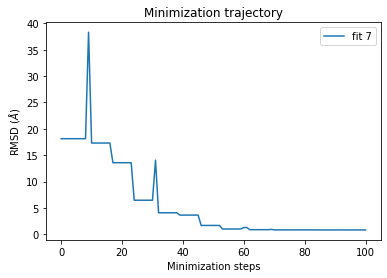

In [5]:
###FIT HELIX 7

target_helix_index = 7

   
    
fig, ax = plt.subplots()
pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).insert_ss_into_pose(pose, True)
all_helix_resis=[]
for chain in pyrosetta.rosetta.core.pose.get_chains(pose):
    current_helix_resis=[]

    for res_num in pyrosetta.rosetta.core.pose.get_resnums_for_chain_id(pose,chain):
        res_ss = pose.secstruct(res_num)
        if res_ss == 'H':
            current_helix_resis.append(res_num)
        else:
            if len(current_helix_resis) >= 3:
                all_helix_resis.append(current_helix_resis)
            current_helix_resis = []
    if len(current_helix_resis) >= 3:
        all_helix_resis.append(current_helix_resis)
num_helices = len(all_helix_resis)



print(f"fitting {target_helix_index}")
ph = ParametricHelix(f'fit {target_helix_index}',True)
single_helix_pose = ph.extract_helix(pose,target_helix_index)

fit = ph.fit_target_helix(single_helix_pose, write_axis=True)
ph.build_helix(-14,16).dump_pdb(f"{target_helix_index}.pdb")
ax = fit.plot_trajectory_rmsd(ax)

#ax = fit.plot_trajectory_parameter('r0',ax)

fit.write_trajectory_movie(f"movie_{target_helix_index}.pdb")

print(fit)

In [6]:
fit.write_trajectory_movie("churro_outer.pdb")

In [7]:
fit.fit

In [8]:
#let's make the context structure
xml_obj = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<RESIDUE_SELECTORS>
   <SSElement name="helix7" 
       selection="7,L" 
       to_selection="8,L" 
       chain="A" />
</RESIDUE_SELECTORS>

<MOVERS>
   <DeleteRegionMover name="delete" residue_selector="helix7"/>
</MOVERS>
""")
delete_helix_7 = xml_obj.get_mover("delete")


In [9]:
context_pose = pyrosetta.Pose()
context_pose.detached_copy(pose)

delete_helix_7.apply(context_pose)
context_pose.dump_pdb("check.pdb")

True

In [10]:
#make valine!
def make_poly_x(pose,x):
    stm = pyrosetta.rosetta.protocols.simple_moves.SimpleThreadingMover()
    stm.set_sequence(x*len(pose.residues),1)
    stm.apply(pose)

In [11]:
make_poly_x(context_pose,"V")



In [12]:
context_pose.dump_pdb("check2.pdb")

True

In [13]:
fp = copy.deepcopy(ph.get_helix_parameters())

In [14]:
#now let's sample around this fit! 
import tqdm

do_run = True

num_r0 = 10
r0_range = 3
r0_start = fp.r0() - r0_range
r0_stop = fp.r0() + r0_range
r0_step = r0_range * 2 / num_r0

num_delta_z = 10
delta_z_range = 5
delta_z_start = fp.delta_z() - delta_z_range
delta_z_stop = fp.delta_z() + delta_z_range
delta_z_step = delta_z_range * 2 / num_delta_z

num_omega = 10
omega0_range = radians(1)
omega0_start = fp.omega0() - omega0_range
omega0_stop = fp.omega0() + omega0_range
omega0_step = omega0_range * 2 / num_omega

num_phi0 = 10
phi0_range = radians(20)
phi0_start = fp.phi0() - phi0_range
phi0_stop = fp.phi0() + phi0_range
phi0_step = phi0_range * 2 / num_phi0




scorefxn = pyrosetta.ScoreFunction() 
scorefxn.set_weight(pyrosetta.rosetta.core.scoring.fa_rep, 1.0) 
scorefxn.set_weight(pyrosetta.rosetta.core.scoring.fa_atr, 1.0) 
scorefxn.set_weight(pyrosetta.rosetta.core.scoring.fa_sol, 1.0) 
context_rep = scorefxn(context_pose)

clash_check_pose = pyrosetta.Pose()
acceptable_helices = []

num_todo = 0
for r0 in np.arange(r0_start,r0_stop,r0_step):
    for delta_z in np.arange(delta_z_start, delta_z_stop, delta_z_step):
        for omega0 in np.arange(omega0_start, omega0_stop, omega0_step):
            for phi0 in np.arange(phi0_start, phi0_stop, phi0_step):
                num_todo += 1

print(f"num_todo! {num_todo}")


bar = tqdm.tqdm_notebook(total = num_todo)

if do_run:
    all_helices = []
    counter = 0
    for r0 in np.arange(r0_start,r0_stop,r0_step):
        for delta_z in np.arange(delta_z_start, delta_z_stop, delta_z_step):
            for omega0 in np.arange(omega0_start, omega0_stop, omega0_step):
                for phi0 in np.arange(phi0_start, phi0_stop, phi0_step):

                    bar.update(1)
                    chp = copy.deepcopy(fp)
                    chp.r0(r0)
                    chp.delta_z(delta_z)
                    chp.omega0(omega0)
                    chp.phi0(phi0)

                    tph = ParametricHelix()
                    tph.set_helix_parameters(chp)

                    name=f"{counter}_{r0:.2f}_{delta_z:.2f}_{degrees(omega0):.2f}_{degrees(phi0):.2f}"

                    #with open(f"test_{name}.pdb",'w') as pdb:
                    #    pdb.write(tph.pdb_str())

                    helix = tph.pose()
                    make_poly_x(helix,"V")

                    helix_rep = scorefxn(helix)
                    clash_check_pose.detached_copy(context_pose)
                    clash_check_pose.append_pose_by_jump(helix,1)
                    merged_rep = scorefxn(clash_check_pose)
                    diff = merged_rep - (helix_rep + context_rep)
                    #print(name, diff)

                    #all_helices.append((name,helix,diff))
                    #this magic number was arrived at by looking at many and seeing which looked like crap and which didn't
                    energy_diff_cutoff = 9000
                    if abs(diff) < energy_diff_cutoff:
                        acceptable_helices.append((name,helix))

                    counter += 1

num_todo! 12100


/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [15]:
import pickle
pickle.dump( acceptable_helices, open( "acceptable_helices.p", "wb" ) )

In [16]:
len(acceptable_helices)

2026

In [ ]:
# for name,helix,diff in sorted(all_helices,key=lambda x: x[2]):
#     helix.dump_pdb(f"V_{name}.pdb")
#     print(name, diff)

In [19]:
import random
for name,helix in random.sample(acceptable_helices,20):
    helix.dump_pdb(f"accepted_{name}.pdb")

In [21]:
#hm, I'm noticing gaps that are bigger than I'd like. 
#i'd better calculate how good of contacts It's making with both parts of the structure


xml_obj = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<RESIDUE_SELECTORS>
   <True name="all"/>
   <SSElement name="left" 
       selection="6,H" 
       to_selection="7,H" 
       chain="A" />

   <SSElement name="right" 
       selection="8,H" 
       to_selection="9,H" 
       chain="A" />
</RESIDUE_SELECTORS>

<FILTERS>
    <BuriedSurfaceArea name="BSA" confidence="0" residue_selector="all"/>
    <BuriedSurfaceArea name="BSA_left" confidence="0" residue_selector="left"/>
    <BuriedSurfaceArea name="BSA_right" confidence="0" residue_selector="right"/>
</FILTERS>
""")
all_burial = xml_obj.get_filter("BSA")
left_burial = xml_obj.get_filter("BSA_left")
right_burial = xml_obj.get_filter("BSA_right")

In [28]:
left_burial_before = left_burial.report_sm(context_pose)
right_burial_before = right_burial.report_sm(context_pose)

In [30]:
#TESTING CELL
burial_check_pose = pyrosetta.Pose()
for name,helix in random.sample(acceptable_helices,20):
    burial_check_pose.detached_copy(context_pose)
    burial_check_pose.append_pose_by_jump(helix,1)
    left_burial_after = left_burial.report_sm(burial_check_pose)
    right_burial_after = right_burial.report_sm(burial_check_pose)
    delta_left = left_burial_after - left_burial_before
    delta_right = right_burial_after - right_burial_before
    
    #took these into pymol and excel and decided by eye which was touching enough on both sides
    #350 as a cutoff for boths sides seems good.
    
    print(name,delta_left,delta_right)
    helix.dump_pdb(f"accepted_{name}.pdb")

11488_24.69_-3.21_-1.23_39.81 488.7321081776581 218.06437665433532
7915_22.89_-2.21_-2.43_47.81 284.17312030333414 549.1063359801574
12047_24.69_1.79_-2.03_31.81 692.413746186573 43.81593236595745
8409_22.89_1.79_-2.23_43.81 458.40480943089005 427.1451170126129
7617_22.89_-5.21_-1.23_43.81 418.96976208570504 381.291563165576
10366_24.09_-2.21_-1.83_39.81 514.5868339402869 275.20593664436274
7189_22.29_1.79_-2.43_47.81 373.3506331067747 495.0665596227336
7001_22.29_-0.21_-1.43_43.81 427.35563474848186 458.47142670918674
8629_23.49_-6.21_-2.63_43.81 275.9521230772307 495.80147510714687
8916_23.49_-4.21_-1.83_47.81 261.6088599009827 472.68283607821104
10027_24.09_-5.21_-1.43_47.81 242.39480941845704 431.2462141187616
10270_24.09_-3.21_-1.43_51.81 150.1495042392189 557.7576848576873
9477_23.49_0.79_-2.63_47.81 369.42459640311336 486.57694458922197
11005_24.69_-7.21_-1.23_43.81 341.9782777460259 290.83828449209796
9366_23.49_-0.21_-2.43_43.81 424.52706883549035 414.83712494071733
11587_24.6

In [41]:
burial_check_pose = pyrosetta.Pose()
left_thresh = 350
right_thresh = 350

burial_filtered_helices = []

for name,helix in tqdm.tqdm_notebook(acceptable_helices):
    print(f"trying {name}")
    burial_check_pose.detached_copy(context_pose)
    burial_check_pose.append_pose_by_jump(helix,1)
    left_burial_after = left_burial.report_sm(burial_check_pose)
    right_burial_after = right_burial.report_sm(burial_check_pose)
    delta_left = left_burial_after - left_burial_before
    delta_right = right_burial_after - right_burial_before
    
    if delta_left > left_thresh and delta_right > right_thresh:
        
        print(f"accepted with {delta_left} and {delta_right}")
        burial_filtered_helices.append((name,helix))


/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


trying 5395_21.69_-3.21_-2.03_43.81
accepted with 404.34231276511946 and 412.9819097590216
trying 5406_21.69_-3.21_-1.83_43.81
accepted with 400.24591641242205 and 417.8550474420226
trying 5417_21.69_-3.21_-1.63_43.81
accepted with 398.54499609361847 and 426.83163260789934
trying 5879_21.69_0.79_-2.03_43.81
accepted with 446.16725109058916 and 438.5068924053221
trying 5890_21.69_0.79_-1.83_43.81
accepted with 436.2664869362152 and 446.8697422360092
trying 5901_21.69_0.79_-1.63_43.81
accepted with 421.72455874897787 and 452.347795523714
trying 6011_21.69_1.79_-1.83_43.81
accepted with 433.79499211712846 and 447.2520856974779
trying 6022_21.69_1.79_-1.63_43.81
accepted with 418.8064535668491 and 449.29822438530937
trying 6033_21.69_1.79_-1.43_43.81
accepted with 413.74640275648653 and 459.1680302772611
trying 6087_22.29_-7.21_-2.63_39.81
accepted with 371.53353591593805 and 404.005324593144
trying 6097_22.29_-7.21_-2.43_35.81
trying 6098_22.29_-7.21_-2.43_39.81
accepted with 390.50434179

accepted with 417.30273218246384 and 458.11180355606757
trying 7188_22.29_1.79_-2.43_43.81
accepted with 460.83035942704737 and 416.12385923547936
trying 7189_22.29_1.79_-2.43_47.81
accepted with 373.3506331067747 and 495.0665596227336
trying 7198_22.29_1.79_-2.23_39.81
trying 7199_22.29_1.79_-2.23_43.81
accepted with 457.50365327448253 and 432.5559712456079
trying 7200_22.29_1.79_-2.23_47.81
trying 7209_22.29_1.79_-2.03_39.81
trying 7210_22.29_1.79_-2.03_43.81
accepted with 452.0270660633487 and 435.5333400521149
trying 7211_22.29_1.79_-2.03_47.81
trying 7220_22.29_1.79_-1.83_39.81
trying 7221_22.29_1.79_-1.83_43.81
accepted with 429.2782429103636 and 442.96260938740033
trying 7222_22.29_1.79_-1.83_47.81
trying 7231_22.29_1.79_-1.63_39.81
accepted with 505.66862809863414 and 350.7149538314343
trying 7232_22.29_1.79_-1.63_43.81
accepted with 406.6045542424217 and 438.8296697186761
trying 7233_22.29_1.79_-1.63_47.81
trying 7242_22.29_1.79_-1.43_39.81
accepted with 509.63914354865756 and

trying 7815_22.89_-3.21_-2.03_43.81
accepted with 381.2821616586725 and 413.75159995915055
trying 7816_22.89_-3.21_-2.03_47.81
trying 7817_22.89_-3.21_-2.03_51.81
trying 7824_22.89_-3.21_-1.83_35.81
trying 7825_22.89_-3.21_-1.83_39.81
trying 7826_22.89_-3.21_-1.83_43.81
accepted with 381.024814799719 and 419.9067711834605
trying 7827_22.89_-3.21_-1.83_47.81
trying 7828_22.89_-3.21_-1.83_51.81
trying 7836_22.89_-3.21_-1.63_39.81
trying 7837_22.89_-3.21_-1.63_43.81
accepted with 388.29577889333814 and 422.53637731874187
trying 7838_22.89_-3.21_-1.63_47.81
trying 7839_22.89_-3.21_-1.63_51.81
trying 7847_22.89_-3.21_-1.43_39.81
trying 7848_22.89_-3.21_-1.43_43.81
accepted with 402.9612376065252 and 415.87356350670507
trying 7849_22.89_-3.21_-1.43_47.81
trying 7850_22.89_-3.21_-1.43_51.81
trying 7858_22.89_-3.21_-1.23_39.81
trying 7859_22.89_-3.21_-1.23_43.81
accepted with 413.15412333556833 and 412.29421124864075
trying 7860_22.89_-3.21_-1.23_47.81
trying 7861_22.89_-3.21_-1.23_51.81
tryin

accepted with 403.08388383231704 and 445.396676590306
trying 8443_22.89_1.79_-1.63_47.81
trying 8452_22.89_1.79_-1.43_39.81
accepted with 508.5820325273089 and 352.34690649522054
trying 8453_22.89_1.79_-1.43_43.81
accepted with 396.5168769606871 and 447.8269273399155
trying 8454_22.89_1.79_-1.43_47.81
trying 8463_22.89_1.79_-1.23_39.81
accepted with 505.66157696845676 and 358.3048787851103
trying 8464_22.89_1.79_-1.23_43.81
accepted with 397.0973036567302 and 456.09015377689775
trying 8465_22.89_1.79_-1.23_47.81
trying 8494_23.49_-7.21_-2.83_31.81
trying 8495_23.49_-7.21_-2.83_35.81
accepted with 399.21887935334144 and 366.9247962220679
trying 8496_23.49_-7.21_-2.83_39.81
trying 8505_23.49_-7.21_-2.63_31.81
trying 8506_23.49_-7.21_-2.63_35.81
trying 8507_23.49_-7.21_-2.63_39.81
trying 8508_23.49_-7.21_-2.63_43.81
trying 8516_23.49_-7.21_-2.43_31.81
trying 8517_23.49_-7.21_-2.43_35.81
trying 8518_23.49_-7.21_-2.43_39.81
trying 8519_23.49_-7.21_-2.43_43.81
trying 8520_23.49_-7.21_-2.43_4

trying 8950_23.49_-4.21_-1.23_51.81
trying 8979_23.49_-3.21_-2.83_35.81
trying 8980_23.49_-3.21_-2.83_39.81
accepted with 419.2026200359978 and 406.3893357531024
trying 8981_23.49_-3.21_-2.83_43.81
trying 8982_23.49_-3.21_-2.83_47.81
trying 8990_23.49_-3.21_-2.63_35.81
trying 8991_23.49_-3.21_-2.63_39.81
accepted with 447.64355141317174 and 356.6779293985146
trying 8992_23.49_-3.21_-2.63_43.81
trying 8993_23.49_-3.21_-2.63_47.81
trying 8994_23.49_-3.21_-2.63_51.81
trying 9001_23.49_-3.21_-2.43_35.81
trying 9002_23.49_-3.21_-2.43_39.81
trying 9003_23.49_-3.21_-2.43_43.81
accepted with 377.9531051293816 and 452.5096379659981
trying 9004_23.49_-3.21_-2.43_47.81
trying 9005_23.49_-3.21_-2.43_51.81
trying 9012_23.49_-3.21_-2.23_35.81
trying 9013_23.49_-3.21_-2.23_39.81
trying 9014_23.49_-3.21_-2.23_43.81
accepted with 379.2374890474148 and 415.09682217639966
trying 9015_23.49_-3.21_-2.23_47.81
trying 9016_23.49_-3.21_-2.23_51.81
trying 9017_23.49_-3.21_-2.23_55.81
trying 9023_23.49_-3.21_-2

accepted with 369.42459640311336 and 486.57694458922197
trying 9478_23.49_0.79_-2.63_51.81
trying 9485_23.49_0.79_-2.43_35.81
trying 9486_23.49_0.79_-2.43_39.81
trying 9487_23.49_0.79_-2.43_43.81
accepted with 441.2316151063269 and 405.61494479952216
trying 9488_23.49_0.79_-2.43_47.81
trying 9489_23.49_0.79_-2.43_51.81
trying 9496_23.49_0.79_-2.23_35.81
trying 9497_23.49_0.79_-2.23_39.81
trying 9498_23.49_0.79_-2.23_43.81
accepted with 430.9570246972344 and 420.22260596490014
trying 9499_23.49_0.79_-2.23_47.81
trying 9500_23.49_0.79_-2.23_51.81
trying 9507_23.49_0.79_-2.03_35.81
trying 9508_23.49_0.79_-2.03_39.81
trying 9509_23.49_0.79_-2.03_43.81
accepted with 412.59671947161223 and 430.47417354190566
trying 9510_23.49_0.79_-2.03_47.81
trying 9511_23.49_0.79_-2.03_51.81
trying 9518_23.49_0.79_-1.83_35.81
trying 9519_23.49_0.79_-1.83_39.81
trying 9520_23.49_0.79_-1.83_43.81
accepted with 399.69232900176576 and 420.8702317156549
trying 9521_23.49_0.79_-1.83_47.81
trying 9522_23.49_0.79_

trying 9972_24.09_-5.21_-2.43_47.81
trying 9973_24.09_-5.21_-2.43_51.81
trying 9979_24.09_-5.21_-2.23_31.81
trying 9980_24.09_-5.21_-2.23_35.81
trying 9981_24.09_-5.21_-2.23_39.81
trying 9982_24.09_-5.21_-2.23_43.81
trying 9983_24.09_-5.21_-2.23_47.81
trying 9984_24.09_-5.21_-2.23_51.81
trying 9985_24.09_-5.21_-2.23_55.81
trying 9990_24.09_-5.21_-2.03_31.81
trying 9991_24.09_-5.21_-2.03_35.81
trying 9992_24.09_-5.21_-2.03_39.81
trying 9993_24.09_-5.21_-2.03_43.81
trying 9994_24.09_-5.21_-2.03_47.81
trying 9995_24.09_-5.21_-2.03_51.81
trying 9996_24.09_-5.21_-2.03_55.81
trying 10001_24.09_-5.21_-1.83_31.81
trying 10002_24.09_-5.21_-1.83_35.81
trying 10003_24.09_-5.21_-1.83_39.81
trying 10004_24.09_-5.21_-1.83_43.81
trying 10005_24.09_-5.21_-1.83_47.81
trying 10006_24.09_-5.21_-1.83_51.81
trying 10007_24.09_-5.21_-1.83_55.81
trying 10012_24.09_-5.21_-1.63_31.81
trying 10013_24.09_-5.21_-1.63_35.81
trying 10014_24.09_-5.21_-1.63_39.81
trying 10015_24.09_-5.21_-1.63_43.81
trying 10016_24.0

trying 10389_24.09_-2.21_-1.43_43.81
accepted with 381.44046690033883 and 392.55606554130645
trying 10390_24.09_-2.21_-1.43_47.81
trying 10391_24.09_-2.21_-1.43_51.81
trying 10398_24.09_-2.21_-1.23_35.81
trying 10399_24.09_-2.21_-1.23_39.81
trying 10400_24.09_-2.21_-1.23_43.81
accepted with 394.14765843576424 and 387.17528527057857
trying 10401_24.09_-2.21_-1.23_47.81
trying 10402_24.09_-2.21_-1.23_51.81
trying 10421_24.09_-1.21_-3.03_39.81
accepted with 433.04764213142334 and 374.6099463397313
trying 10422_24.09_-1.21_-3.03_43.81
accepted with 372.5699744819258 and 426.1039776931757
trying 10431_24.09_-1.21_-2.83_35.81
trying 10432_24.09_-1.21_-2.83_39.81
trying 10433_24.09_-1.21_-2.83_43.81
accepted with 365.39481732871263 and 406.3752334927458
trying 10434_24.09_-1.21_-2.83_47.81
trying 10442_24.09_-1.21_-2.63_35.81
trying 10443_24.09_-1.21_-2.63_39.81
trying 10444_24.09_-1.21_-2.63_43.81
accepted with 356.4323344231925 and 404.8429042226653
trying 10445_24.09_-1.21_-2.63_47.81
tryi

trying 10808_24.09_1.79_-2.63_47.81
accepted with 375.8601373184638 and 422.51757430493217
trying 10809_24.09_1.79_-2.63_51.81
trying 10810_24.09_1.79_-2.63_55.81
trying 10816_24.09_1.79_-2.43_35.81
trying 10817_24.09_1.79_-2.43_39.81
trying 10818_24.09_1.79_-2.43_43.81
trying 10819_24.09_1.79_-2.43_47.81
trying 10820_24.09_1.79_-2.43_51.81
trying 10821_24.09_1.79_-2.43_55.81
trying 10826_24.09_1.79_-2.23_31.81
trying 10827_24.09_1.79_-2.23_35.81
trying 10828_24.09_1.79_-2.23_39.81
trying 10829_24.09_1.79_-2.23_43.81
accepted with 419.3948156932247 and 366.1504052684859
trying 10830_24.09_1.79_-2.23_47.81
trying 10831_24.09_1.79_-2.23_51.81
trying 10832_24.09_1.79_-2.23_55.81
trying 10837_24.09_1.79_-2.03_31.81
trying 10838_24.09_1.79_-2.03_35.81
trying 10839_24.09_1.79_-2.03_39.81
trying 10840_24.09_1.79_-2.03_43.81
accepted with 389.7352333761555 and 385.1212111524146
trying 10841_24.09_1.79_-2.03_47.81
trying 10842_24.09_1.79_-2.03_51.81
trying 10843_24.09_1.79_-2.03_55.81
trying 10

trying 11225_24.69_-5.21_-1.63_43.81
trying 11226_24.69_-5.21_-1.63_47.81
trying 11227_24.69_-5.21_-1.63_51.81
trying 11228_24.69_-5.21_-1.63_55.81
trying 11234_24.69_-5.21_-1.43_35.81
trying 11235_24.69_-5.21_-1.43_39.81
trying 11236_24.69_-5.21_-1.43_43.81
trying 11237_24.69_-5.21_-1.43_47.81
trying 11238_24.69_-5.21_-1.43_51.81
trying 11239_24.69_-5.21_-1.43_55.81
trying 11245_24.69_-5.21_-1.23_35.81
trying 11246_24.69_-5.21_-1.23_39.81
trying 11247_24.69_-5.21_-1.23_43.81
trying 11248_24.69_-5.21_-1.23_47.81
trying 11249_24.69_-5.21_-1.23_51.81
trying 11267_24.69_-4.21_-3.03_35.81
accepted with 375.65108565916853 and 392.2916675521765
trying 11277_24.69_-4.21_-2.83_31.81
trying 11278_24.69_-4.21_-2.83_35.81
trying 11279_24.69_-4.21_-2.83_39.81
trying 11280_24.69_-4.21_-2.83_43.81
trying 11287_24.69_-4.21_-2.63_27.81
trying 11288_24.69_-4.21_-2.63_31.81
trying 11289_24.69_-4.21_-2.63_35.81
trying 11290_24.69_-4.21_-2.63_39.81
trying 11291_24.69_-4.21_-2.63_43.81
trying 11292_24.69_-

trying 11668_24.69_-1.21_-2.43_55.81
trying 11673_24.69_-1.21_-2.23_31.81
trying 11674_24.69_-1.21_-2.23_35.81
trying 11675_24.69_-1.21_-2.23_39.81
trying 11676_24.69_-1.21_-2.23_43.81
accepted with 352.8529821651264 and 367.95418365787555
trying 11677_24.69_-1.21_-2.23_47.81
trying 11678_24.69_-1.21_-2.23_51.81
trying 11679_24.69_-1.21_-2.23_55.81
trying 11684_24.69_-1.21_-2.03_31.81
trying 11685_24.69_-1.21_-2.03_35.81
trying 11686_24.69_-1.21_-2.03_39.81
trying 11687_24.69_-1.21_-2.03_43.81
trying 11688_24.69_-1.21_-2.03_47.81
trying 11689_24.69_-1.21_-2.03_51.81
trying 11690_24.69_-1.21_-2.03_55.81
trying 11695_24.69_-1.21_-1.83_31.81
trying 11696_24.69_-1.21_-1.83_35.81
trying 11697_24.69_-1.21_-1.83_39.81
trying 11698_24.69_-1.21_-1.83_43.81
trying 11699_24.69_-1.21_-1.83_47.81
trying 11700_24.69_-1.21_-1.83_51.81
trying 11701_24.69_-1.21_-1.83_55.81
trying 11706_24.69_-1.21_-1.63_31.81
trying 11707_24.69_-1.21_-1.63_35.81
trying 11708_24.69_-1.21_-1.63_39.81
trying 11709_24.69_-

trying 12063_24.69_1.79_-1.83_51.81
trying 12064_24.69_1.79_-1.83_55.81
trying 12069_24.69_1.79_-1.63_31.81
trying 12070_24.69_1.79_-1.63_35.81
trying 12071_24.69_1.79_-1.63_39.81
trying 12072_24.69_1.79_-1.63_43.81
trying 12073_24.69_1.79_-1.63_47.81
trying 12074_24.69_1.79_-1.63_51.81
trying 12075_24.69_1.79_-1.63_55.81
trying 12080_24.69_1.79_-1.43_31.81
trying 12081_24.69_1.79_-1.43_35.81
trying 12082_24.69_1.79_-1.43_39.81
trying 12083_24.69_1.79_-1.43_43.81
trying 12084_24.69_1.79_-1.43_47.81
trying 12085_24.69_1.79_-1.43_51.81
trying 12086_24.69_1.79_-1.43_55.81
trying 12092_24.69_1.79_-1.23_35.81
trying 12093_24.69_1.79_-1.23_39.81
trying 12094_24.69_1.79_-1.23_43.81
trying 12095_24.69_1.79_-1.23_47.81
trying 12096_24.69_1.79_-1.23_51.81



In [42]:
import pickle
pickle.dump( burial_filtered_helices, open( "burial_filtered_helices.pkl", "wb" ) )

In [40]:
import random
for name, helix in random.sample(burial_filtered_helices,30):
    helix.dump_pdb(f"filtered_{name}.pdb")

In [43]:
len(burial_filtered_helices)

323

In [47]:
#that's enough to dump and do connectchainsmover on!
output_pose = pyrosetta.Pose()

#os.mkdir("output")

for name,helix in tqdm.tqdm_notebook(acceptable_helices):
    output_pose.detached_copy(context_pose)
    output_pose.append_pose_by_jump(helix,1)
    
    output_pose.dump_pdb(f"output/{name}.pdb")

/home/rdkibler/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  
